In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pylab as plt
np.random.seed(2020)

In [2]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [3]:
# Stock Price
    
def StockPrice(S, r, t, sigma, W):
    return S*np.exp((r*t-0.5*sigma**2*t)+sigma*W)

In [4]:
# Phi and PsiB
    
def Phi(S, K, r, sigma, T, t):
        d1 = (np.log(S/K) + (r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
        return norm.cdf(d1)

def Psi_Bt(S, K, r, sigma, T, t):
        d2 = (np.log(S/K) + (r-0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
        return -K*np.exp(-r*(T-t))*norm.cdf(d2)

In [5]:
# Brownian Motion
    
def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)

In [6]:
# Hedging Error
    
def HedgingError(S0, K, r, sigma, T, t, x):
    S = pd.DataFrame(StockPrice(S0, r, t, sigma, x))
    phi = pd.DataFrame(Phi(S, K, r, sigma, T, t))
    psib = pd.DataFrame(Psi_Bt(S, K, r, sigma, T, t))
    hedging_error = pd.DataFrame(phi.values[:,:-1]*np.diff(S) + psib.values[:,:-1]*r*(T/len(t)))
    hedging_error['Sum'] = hedging_error.apply(np.sum, axis = 1)
    payoff = np.maximum(S-K, 0)
    call_option = BlackScholesCall(S0, K, r, sigma, T)
    final_PL = hedging_error['Sum'].values + call_option - payoff.iloc[:,-1]
    return final_PL

In [7]:
# Params
    
S0 = 100
sigma = 0.2
r = 0.05
T = 1/12
K = 100
N1 = 21
N2 = 84
paths = 50000

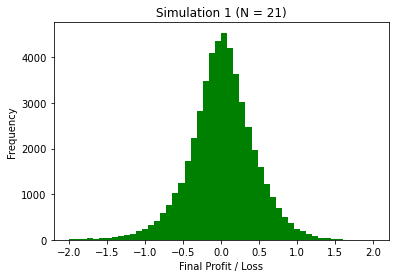

In [8]:
# Simulation 1
    
t1, x = simulate_Brownian_Motion(paths, N1, T)
    
simulation1 = HedgingError(S0, K, r, sigma, T, t1, x)

plt.hist(simulation1, bins=50, range=[-2, 2], facecolor='green', align='mid')
plt.title('Simulation 1 (N = 21)')
plt.xlabel('Final Profit / Loss')
plt.ylabel('Frequency')
plt.show()

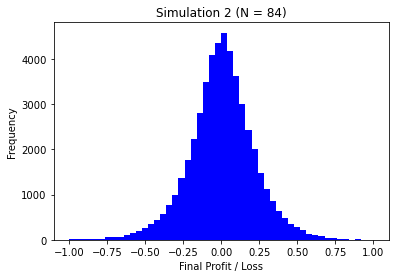

In [9]:
# Simulation 2

t2, x2 = simulate_Brownian_Motion(paths, N2, T)

simulation2 = HedgingError(S0, K, r, sigma, T, t2, x2)

plt.hist(simulation2, bins=50, range=[-1, 1], facecolor='blue', align='mid')
plt.title('Simulation 2 (N = 84)')
plt.xlabel('Final Profit / Loss')
plt.ylabel('Frequency')
plt.show()

In [10]:
dt2= T/N2

blackscholespath2 = S0*np.exp((r-sigma**2/2)*t2 + sigma*x2[0])


<ipython-input-4-8d0a6d24e7ae>:4: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(S/K) + (r+0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))
<ipython-input-4-8d0a6d24e7ae>:8: RuntimeWarning: divide by zero encountered in double_scalars
  d2 = (np.log(S/K) + (r-0.5*sigma**2)*(T-t))/(sigma*np.sqrt(T-t))


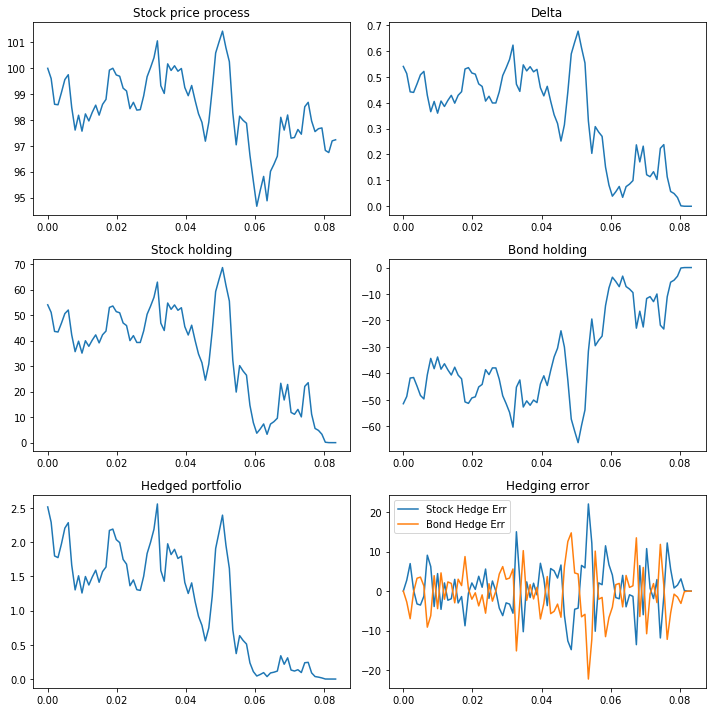

In [11]:
#Using N=84 to get the following diagrams

deltas = []
stockhedge_errors = []
bondhedge_errors = []
hedged_portfolios = []
stock_holdings = []
bond_holdings = []
for t, S_t in zip(t2, blackscholespath2):
    stock_pos = Phi(S_t, K, r, sigma, T, t)*S_t
    bond_pos = Psi_Bt(S_t, K, r, sigma, T, t)
    V_t = stock_pos + bond_pos
    stock_holdings.append(stock_pos)
    bond_holdings.append(bond_pos)
    hedged_portfolios.append(V_t)
    deltas.append(Phi(S_t, K, r, sigma, T, t))
    if t == 0.0:
        stockhedge_errors.append(0)
        bondhedge_errors.append(0)
    else:
        stockhedge_errors.append(prev_phi*S_t - stock_pos)
        bondhedge_errors.append(prev_bond_pos*np.exp(r*dt2) - bond_pos)

    prev_phi = Phi(S_t, K, r, sigma, T, t)
    prev_bond_pos = bond_pos

plt.figure(tight_layout=True, figsize=(10, 10))
plt.subplot(321)
plt.plot(t2, blackscholespath2)
plt.title('Stock price process')
plt.subplot(322)
plt.plot(t2, deltas)
plt.title('Delta')
plt.subplot(323)
plt.plot(t2, stock_holdings)
plt.title('Stock holding')
plt.subplot(324)
plt.plot(t2, bond_holdings)
plt.title('Bond holding')
plt.subplot(325)
plt.plot(t2, hedged_portfolios)
plt.title('Hedged portfolio')
plt.subplot(326)
plt.plot(t2, stockhedge_errors, label='Stock Hedge Err')
plt.plot(t2, bondhedge_errors, label='Bond Hedge Err')
plt.legend()
plt.title('Hedging error')
plt.show()
